In [48]:
# Imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [49]:
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")

# Separate features
num_features = [
    "Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"
]

cat_features = [
    "Gender", "family_history_with_overweight", "FAVC", "CAEC",
    "SMOKE", "SCC", "CALC", "MTRANS"
]


# Pipelines for each type of feature
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# Drop the class label
X_clustering = df.drop("NObeyesdad", axis=1)

# Apply the same preprocessing pipeline as before
X_clust_transformed = full_pipeline.fit_transform(X_clustering)

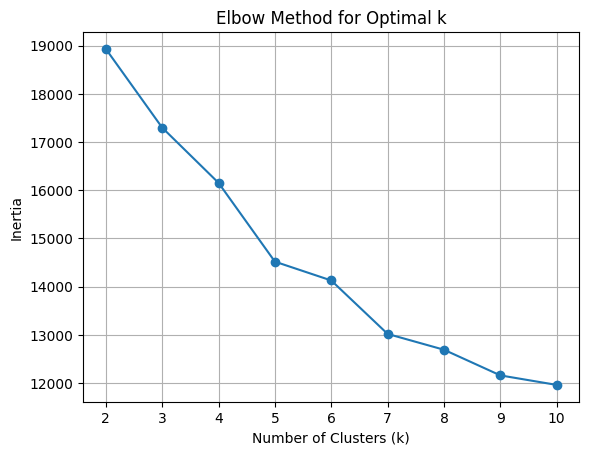

In [50]:
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_clust_transformed)
    inertias.append(kmeans.inertia_)

plt.plot(k_range, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

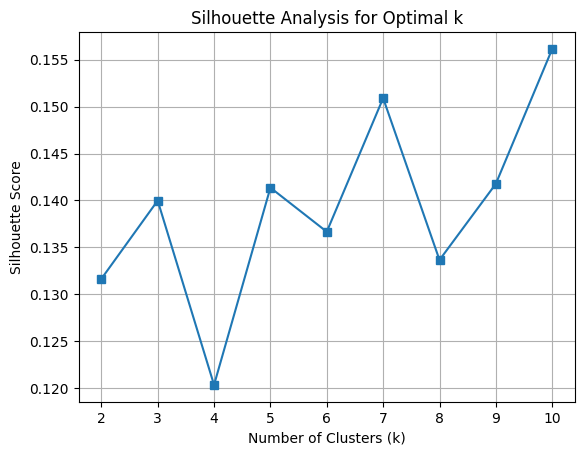

In [51]:
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_clust_transformed)
    score = silhouette_score(X_clust_transformed, labels)
    silhouette_scores.append(score)

plt.plot(k_range, silhouette_scores, marker='s')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Optimal k")
plt.grid(True)
plt.show()

In [52]:
# Replace with the k value you chose from elbow/silhouette
optimal_k = 7

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans_final.fit_predict(X_clust_transformed)

# Add clusters to the original DataFrame
df["Cluster"] = clusters

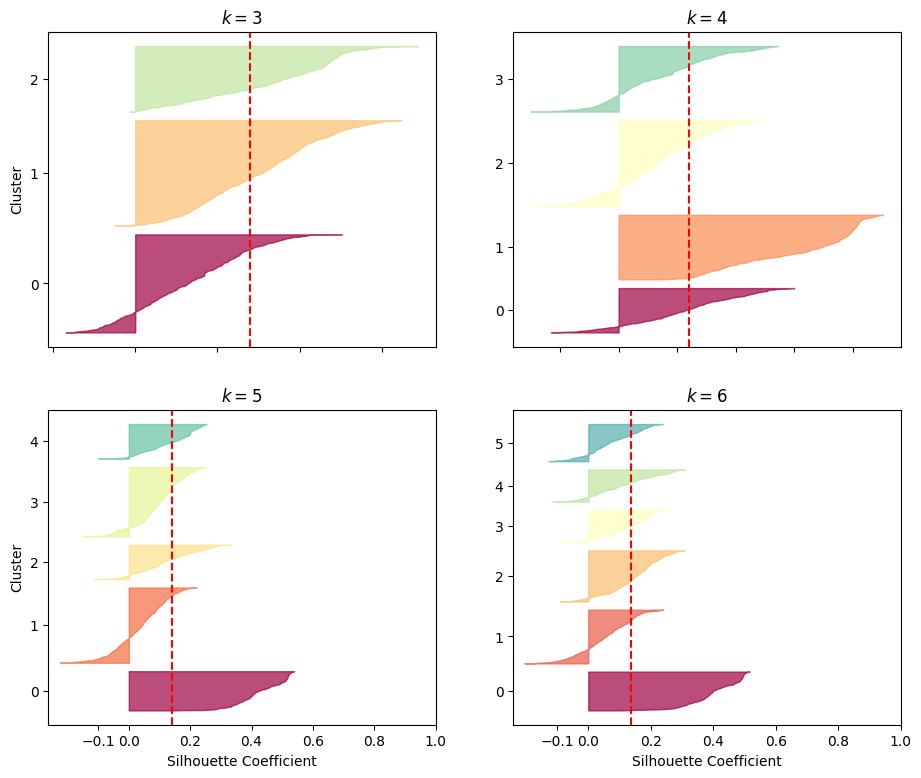

In [ ]:
# extra code – this cell generates and saves Figure 9–10

from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import numpy as np
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_clust_transformed)
                for k in range(1, 10)]

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_clust_transformed, y_pred)

    padding = len(X_clust_transformed) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

In [53]:
# You can summarize selected numerical features per cluster
cluster_summary = df.groupby("Cluster").describe(include='all')
print(cluster_summary)

        Gender                                                    ...  \
         count unique     top freq mean  std  min  25%  50%  75%  ...   
Cluster                                                           ...   
0          262      2  Female  170  NaN  NaN  NaN  NaN  NaN  NaN  ...   
1          270      2  Female  146  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2          279      2  Female  234  NaN  NaN  NaN  NaN  NaN  NaN  ...   
3          282      2    Male  254  NaN  NaN  NaN  NaN  NaN  NaN  ...   
4          333      2  Female  330  NaN  NaN  NaN  NaN  NaN  NaN  ...   
5          283      2    Male  149  NaN  NaN  NaN  NaN  NaN  NaN  ...   
6          402      2    Male  401  NaN  NaN  NaN  NaN  NaN  NaN  ...   

        NObeyesdad                                                          \
            unique                  top freq mean  std  min  25%  50%  75%   
Cluster                                                                      
0                6   Overweight_Lev

In [71]:
list(df["NObeyesdad"].unique())

['Normal_Weight',
 'Overweight_Level_I',
 'Overweight_Level_II',
 'Obesity_Type_I',
 'Insufficient_Weight',
 'Obesity_Type_II',
 'Obesity_Type_III']

In [55]:
for i in list(df.columns.values):
    aggregated_data = df.groupby("Cluster")[i].describe()
    print(aggregated_data)

        count unique     top freq
Cluster                          
0         262      2  Female  170
1         270      2  Female  146
2         279      2  Female  234
3         282      2    Male  254
4         333      2  Female  330
5         283      2    Male  149
6         402      2    Male  401
         count       mean       std        min        25%        50%  \
Cluster                                                                
0        262.0  21.662312  3.054317  16.000000  19.861722  21.014596   
1        270.0  36.961294  5.503297  27.899784  33.073006  37.398666   
2        279.0  20.762305  2.515959  16.000000  19.000000  20.400053   
3        282.0  20.715921  3.622188  14.000000  18.000000  19.967065   
4        333.0  23.477171  2.766759  18.000000  21.016849  25.289428   
5        283.0  21.070272  3.281559  16.000000  18.003371  21.000000   
6        402.0  25.506134  4.291038  17.000000  22.345409  25.136602   

               75%        max  
Cluster      

In [57]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X_clustering.select_dtypes(include=['object']))
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(X_clustering.select_dtypes(include=['object']).columns))
numerical_cols = X_clustering.select_dtypes(include=['int64', 'float64']).columns
final = pd.concat([X_encoded_df, X_clustering[numerical_cols].reset_index(drop=True)], axis=1)
final

,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,...,MTRANS_Public_Transportation,MTRANS_Walking,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,21.000000,1.620000,64.000000,2.0,3.0,2.000000,0.000000,1.000000
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,21.000000,1.520000,56.000000,3.0,3.0,3.000000,3.000000,0.000000
2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,23.000000,1.800000,77.000000,2.0,3.0,2.000000,2.000000,1.000000
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,27.000000,1.800000,87.000000,3.0,3.0,2.000000,2.000000,0.000000
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,22.000000,1.780000,89.800000,2.0,1.0,2.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,20.976842,1.710730,131.408528,3.0,3.0,1.728139,1.676269,0.906247
2107,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,21.982942,1.748584,133.742943,3.0,3.0,2.005130,1.341390,0.599270
2108,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,22.524036,1.752206,133.689352,3.0,3.0,2.054193,1.414209,0.646288
2109,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,24.361936,1.739450,133.346641,3.0,3.0,2.852339,1.139107,0.586035


In [59]:
# Use the same transformed features, but clusters as labels
X_train, X_test, y_train, y_test = train_test_split(
    final, df["Cluster"], test_size=0.3, random_state=42
)

tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)

print("Decision Tree Classifier on Clusters:")
print(classification_report(y_test, y_pred))

Decision Tree Classifier on Clusters:
              precision    recall  f1-score   support

           0       0.93      0.83      0.87        75
           1       0.86      0.91      0.89        70
           2       0.73      0.67      0.70        89
           3       0.64      0.62      0.63        89
           4       1.00      0.97      0.98       100
           5       0.53      0.77      0.63        90
           6       0.85      0.69      0.76       121

    accuracy                           0.77       634
   macro avg       0.79      0.78      0.78       634
weighted avg       0.79      0.77      0.78       634



In [60]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [61]:
X_clust_transformed.shape

(2111, 31)

In [67]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=str(IMAGES_PATH / "iris_tree.dot"),  # path differs in the book
        feature_names=final.columns.tolist(),
        class_names=[str(cls) for cls in tree_clf.classes_],
        rounded=True,
        filled=True
    )

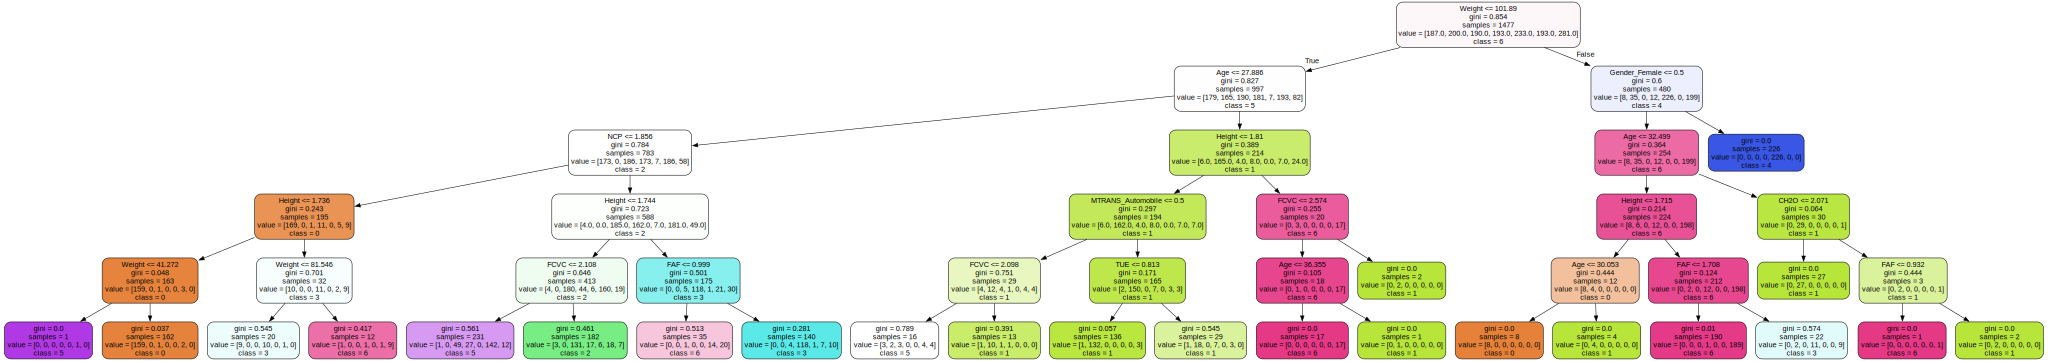

In [68]:
from graphviz import Source

Source.from_file(IMAGES_PATH / "iris_tree.dot")  # path differs in the book

In [ ]:
# Cross-tabulation of original classes vs new clusters
cross_tab = pd.crosstab(df["NObeyesdad"], df["Cluster"])

# Heatmap to visualize how clusters align with classes
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Cross-tab: Obesity Class vs. Cluster")
plt.ylabel("Obesity Class")
plt.xlabel("Cluster")
plt.show()

# Were you able to identify unique characteristics for each/some clusters?
In help with the the functions groupby and describe we could get unique characteristics from each cluster and with help of graphviz on the tree clasiffier we explore in deep and see how the tree clasifier classify the clusters and give us information about unique charcteiristics.